# Empirical modelling of data



Here I will test modelling the multiband data as part of an empirical prior model. To illustrate and validate this I will carry out the following steps:
1. Model simulation distribution
2. Model simulation distribution with cuts
3. Model simulation distribution from map

In [7]:
import numpy as np
import pylab as plt
import seaborn as sns
%matplotlib inline

In [8]:
from astropy.table import Table

In [9]:
mock=Table.read('../../../test_files/lacey_07012015_MillGas.ALLVOLS_cat_PSW_COSMOS_test.fits')

In [10]:
mock[0:10]

DHALOID,GALAXYID,S100,S160,S250,S350,S500,APPUSO_TOT_EXT,APPGSO_TOT_EXT,APPRSO_TOT_EXT,APPISO_TOT_EXT,APPZSO_TOT_EXT,DEC,IS_CENTRAL,MHHALO,MSTARDOT,MSTARS_TOT,RA,Z_COS,Z_OBS
str22,str22,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float32,float32
7221000005,250660000005,0.184557,0.847295,1.00324,0.666443,0.30983,21.0851,19.9199,19.3745,19.1446,18.9669,2.52281435887,0.0,1.12367e+11,8.41508e+07,1.02091e+09,149.968831368,0.102633,0.100918
7354000005,252230000005,0.879098,2.2013,1.80466,0.997061,0.40618,20.3638,19.3247,18.8853,18.698,18.5506,1.09296587368,0.0,1.81679e+11,1.88512e+08,1.15188e+09,149.996199092,0.092121,0.0912445
4026000013,210160000013,0.0112136,0.0411177,0.0405248,0.0241011,0.0102681,25.039,23.1625,21.7082,21.1741,20.85,2.10696062174,0.0,2.84672e+11,2.00169e+06,6.09953e+09,149.137297107,0.376282,0.376532
4726000013,219730000013,0.0652038,0.208996,0.191553,0.110243,0.0459506,23.3759,22.8123,21.79,21.5169,21.3217,2.56423522875,0.0,2.80937e+11,3.34448e+08,1.60865e+09,150.92582623,0.376829,0.377374
5536000013,230270000013,0.103659,0.455567,0.496569,0.309403,0.13604,22.8201,22.3489,21.3669,21.1046,20.9246,2.16826441305,0.0,1.81664e+11,5.8204e+08,2.28481e+09,149.524681469,0.377186,0.377635
5762000013,233190000013,0.136709,0.615261,0.677913,0.424214,0.187012,22.8012,22.2651,21.2245,20.9151,20.6908,1.88389672817,0.0,1.76046e+11,6.97228e+08,3.16073e+09,149.729887985,0.383715,0.3851
9150000013,272530000013,0.0201797,0.105251,0.130986,0.0878964,0.0408579,23.9817,23.5002,22.5123,22.2561,22.0729,2.41002832928,0.0,8.80211e+10,1.92794e+08,7.69563e+08,149.891553543,0.381552,0.382695
4424000012,215640000012,0.0270184,0.146568,0.192646,0.136105,0.0665875,23.3157,22.8147,22.039,21.8566,21.7233,1.40785718228,0.0,1.55454e+11,2.51134e+08,6.29514e+08,150.436258903,0.327132,0.325931
24026571,1840000011,39.481,67.4472,45.2025,23.0549,8.96614,23.275,21.9669,20.7596,20.2263,19.9311,2.15883520338,0.0,2.30369e+11,5.59299e+09,2.42265e+10,149.563597856,0.292259,0.293412


/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


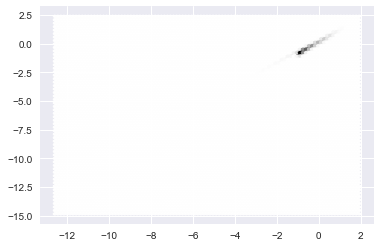

In [11]:
plt.hexbin(np.log10(mock['S500']),np.log10(mock['S350']))

In [12]:
np.log10(mock['S250'])

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


0.0014038
0.256394
-1.39228
-0.71771
-0.30402
-0.168826
-0.882775
-0.71524
1.65516
0.0500957
-0.438123


In [13]:
model="""
data {
  int N;
  vector[N] y;
  int n_groups;
}
parameters {
  ordered[n_groups] mu;
  vector<lower = 0>[n_groups] sigma;
  simplex[n_groups] Theta;
}
model {
  vector[n_groups] contributions;
  // priors
  mu ~ normal(0, 10);
  sigma ~ cauchy(0, 2);
  Theta ~ dirichlet(rep_vector(2.0, n_groups));
  
  
  // likelihood
  for(i in 1:N) {
    for(k in 1:n_groups) {
      contributions[k] = log(Theta[k]) + normal_lpdf(y[i] | mu[k], sigma[k]);
    }
    target += log_sum_exp(contributions);
  }
}
"""

In [14]:
import pystan

In [15]:
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_37bc72dc5f55ae5520f6a45833bba460 NOW.


In [37]:
data={'N':np.isfinite(np.log10(mock['S250'][0:400])).sum(),
      'y':np.log10(mock['S250'])[0:400][np.isfinite(np.log10(mock['S250'][0:400]))],
      'n_groups':1}

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


In [38]:
fit=sm.sampling(data=data, iter=4000)

In [39]:
fit

Inference for Stan model: anon_model_37bc72dc5f55ae5520f6a45833bba460.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]     -1.22  7.9e-4   0.06  -1.34  -1.26  -1.22  -1.17   -1.1   5951    1.0
sigma[0]   1.15  5.5e-4   0.04   1.07   1.12   1.15   1.18   1.24   6177    1.0
Theta[0]    1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   8000    nan
lp__     -560.2    0.02   1.01 -562.9 -560.6 -559.9 -559.5 -559.2   3759    1.0

Samples were drawn using NUTS at Wed Jul  5 15:47:19 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


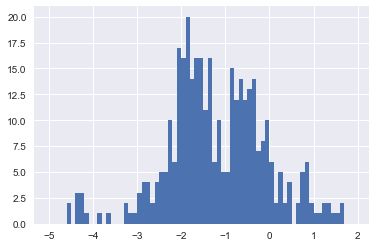

In [34]:
plt.hist(np.log10(mock['S250'])[0:400][np.isfinite(np.log10(mock['S250'][0:400]))], bins=np.arange(-5,2,0.1));

In [100]:
model="""
data {
  int N;
  int D;
  vector[D] y[N];
  int n_groups;
}
parameters {
  ordered[n_groups] mu_S250;
  vector[D-1] mu_other[n_groups];
  cholesky_factor_corr[D] L[n_groups];
  simplex[n_groups] Theta;

}
transformed parameters {
  vector[D] mu_all[n_groups];
  for (n in 1:n_groups){
  mu_all[n,1]=mu_S250[n];
  mu_all[n,2]=mu_other[n,1];
  }
  

  
  


}
model {
  vector[n_groups] contributions;
  // priors
  mu_S250~normal(0, 10);
  for (i in 1:D-1){
  mu_other[i] ~ normal(0, 10);
  }
  Theta ~ dirichlet(rep_vector(2.0, n_groups));
  
  
  // likelihood
  for(i in 1:N) {
    for(k in 1:n_groups) {
      contributions[k] = log(Theta[k]) + multi_normal_cholesky_lpdf(y[i] | mu_all[k], L[k]);
    }
    target += log_sum_exp(contributions);
  }
}
"""

In [101]:
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ef96a8f4f58d9fe4ab7a945bea0f749 NOW.


In [102]:
ind=np.isfinite(np.log10(mock['S250'][0:400])) & np.isfinite(np.log10(mock['S350'][0:400]))

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


In [103]:
y=np.vstack((np.log10(mock['S250'][0:400])[ind],np.log10(mock['S350'][0:400])[ind]))

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


In [107]:
data={'N':ind.sum(),
      'D':2,
      'y':y.T,
      'n_groups':2}

In [108]:
fit=sm.sampling(data=data, iter=2000)

In [109]:
fit

Inference for Stan model: anon_model_9ef96a8f4f58d9fe4ab7a945bea0f749.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_S250[0]      -3.0    0.75   1.07  -4.16  -3.73  -3.47   -1.9  -1.15      2   4.13
mu_S250[1]      1.03    2.89   5.01  -1.19  -1.11  -1.06  -0.94  17.41      3   1.51
mu_other[0,0]  -2.98    0.67   0.95  -4.07  -3.64  -3.39   -2.0  -1.35      2   3.75
mu_other[1,0]-2.5e12  3.2e12 4.6e12-1.3e13  -1.46  -1.32  -1.27  -1.19      2   3.41
mu_other[0,1]  -0.01    0.16   10.1 -19.64  -6.86   0.02   6.82  19.36   4000    1.0
mu_other[1,1]-1.1e11  1.1e11 5.3e11-1.6e12 -2.4e8 -2.5e7  2.7e6 9.2e11     22   1.16
L[0,0,0]         1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   4000    nan
L[1,0,0]         1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   4000    nan
L[0,1,0]         1.0  8.7e-4 2.3e-3   0.99   0